## Create numpy array for feature vector and costmap and save them
### Do the following for all situations in all scenarios
* Loop through whole numpy array of gridmap, init_path, opt_path, car_odo
* For each **gridmap**, **init_path**, **opt_path**, **car_odo** calculate **diff_path**, **cost_map**, **feature_vector** representing neighbours of each point

In [2]:
import numpy as np
from numpy import ndarray
import os
import matplotlib.pyplot as plt
from time import time
from typing import List
from pathlib import Path
from fnmatch import fnmatch
from tqdm import tqdm,trange

In [92]:
# get all _grid.npz
# replace _grid with respective file name
# while looping get indices where paths are unequal

source_path = r'C:\Users\Teja\Documents\_INFOTECH\Thesis\sample_Ros_bag\np_data\raw_data_wo_img'
pattern = '*_grid.npz'

def get_all_grid_paths(root_dir:Path, file_pattern:str='*_grid.npz',print_path:bool=False)->List:
    list_gridmap_loc=[]
    for path, subdirs, files in os.walk(source_path):
        for name in files:
            if fnmatch(name, pattern):
                if print_path:
                    print(os.path.join(path, name))
                list_gridmap_loc.append(os.path.join(path,name))

    return list_gridmap_loc
 
gridmap_locs = get_all_grid_paths(root_dir=source_path,file_pattern=pattern,print_path=False)
print(len(gridmap_locs))

159


In [27]:
def transform_coord(path,grid_info):
    assert grid_info.shape[0] == 3
    if len(path.shape)==2:
        assert path.shape[1]==2
        org = grid_info[0:2]
        res = grid_info[2]
        return (path-org)/res
    elif len(path.shape)==1:
        assert path.shape[0]==2
        org = grid_info[0:2]
        res = grid_info[2]
        return (path-org)/res

def load_np_data(grid_path:str):
    #0,127
    test_grid_data = np.load(file=grid_path)['grid_data']
    test_org_res = np.load(file=grid_path)['grid_org_res']
    # real world coords
    test_init_data = np.load(file=grid_path.replace('_grid','_init_path'))['init_path']
    test_opt_data = np.load(file=grid_path.replace('_grid','_opt_path'))['opt_path']
    test_odo_data = np.load(file=grid_path.replace('_grid','_odo'))['odo_data']

    print(f"grid shape:{test_grid_data.shape},org_res:{test_org_res.shape},init_path:{test_init_data.shape}")
    return test_grid_data,test_org_res,test_init_data,test_opt_data,test_odo_data

def calc_direction_cost(car_coords:ndarray,endpoint_unit_normal:ndarray,vector:ndarray):
    direction = car_coords-vector
    direction_unit = direction/np.linalg.norm(x=direction)

    direction_cost = np.dot(direction_unit,endpoint_unit_normal)

    return direction_cost

def calc_costmap(gridmap:ndarray,gd_org_res:ndarray,car_odo:ndarray,initial_path:ndarray,include_dir_cost:bool=True,distance_mag:float=0.23)->ndarray:
    """Function to transfor grid map to cost map

    Args:
        gridmap (ndarray): Binary occupancy grid map
        car_odo (ndarray): [description]
        initial_path (ndarray): [description]
        distance_mag (float, optional): lower it is larger cost considered for the occupied cells. Defaults to 0.40.

    Returns:
        ndarray: [description]
    """
    
    car_coords = car_odo[0:2]
    end_coords = initial_path[-1]
    
    # Normalize coordinates to 0-1536 range
    #car_coords = (car_coords-gd_org_res[0:2])/gd_org_res[2]
    #end_coords = (end_coords-gd_org_res[0:2])/gd_org_res[2]

    # Initialize distance and direction costmap 
    dist_costmap = np.zeros(shape=(1536,1536))
    dir_costmap =  np.zeros(shape=(1536,1536))

    ################# calculate distance costmap ################
    
    # get occuppied cell indices
    (y,x) = np.where(gridmap==np.max(gridmap))
    # create coordinate pairs of location of occupied cells
    coords = np.array((x,y)).T

    # eucledian difference
    distance = np.square(coords-car_coords)
    distance = np.sum(distance, axis=1)
    distance = 1/(distance**distance_mag)
    dist_costmap[(y,x)]=distance

    ################# Direction cost map ######################
    
    if include_dir_cost:

        # end point direction
        direction_vector = car_coords-end_coords

        # unit vector between, car location and end point
        end_dir_unit = direction_vector/np.linalg.norm(x=direction_vector)

        # calculate dir cost for all occupied cell locations
        direction_cost= np.asarray([calc_direction_cost(car_coords=car_coords,endpoint_unit_normal=end_dir_unit,vector=coord) for coord in coords])

        # zero down all opposite directions to end point
        direction_cost[np.where(direction_cost<0)]=0.0

        dir_costmap[(y,x)] = direction_cost
    else:
        dir_costmap = np.ones(shape=(1536,1536))

    # pointwise multiply distance cost and direction cost
    costmap = dist_costmap*dir_costmap

    # normalize cost map between [0,1]
    costmap = costmap/np.max(costmap)
    #cp=r'C:\Users\Teja\Documents\_INFOTECH\Thesis\sample_Ros_bag\npzcostmaps'
    #np.savez_compressed(os.path.join(cp,file_details.decode("utf-8").split('/')[-1]),grid_data=costmap.astype(np.float16))
    return costmap.astype(float)

def get_feature_vector(gridmap:ndarray,init_path:ndarray,offset)->ndarray:
    feature_vector = np.zeros(shape=(init_path.shape[0],4*offset[0]*offset[1]))
    # np.array(init_path.shape[0],4*offset[0]*offset[1])
    for i in range(init_path.shape[0]):
        x_l,y_l = (init_path[i].astype(int)) - offset
        x_h,y_h = (init_path[i].astype(int)) + offset
        cell = 0
        #print("lower:",(x_l,y_l))
        #print("higher:",(x_h,y_h))

        for x in range(x_l,x_h):
            for y in range(y_l,y_h):
                #print(x,y)
                if cell<feature_vector.shape[1]:
                    #gridmap[row][column]
                    feature_vector[i][cell] = gridmap[y][x]
                    cell+=1
    return feature_vector


def check_imbalance(init_path_arr,opt_path_arr):
    count=0
    zero_paths = 0
    indices = []
    assert len(opt_path_arr)==len(init_path_arr)
    for i in range(len(init_path_arr)):
        if np.array_equal(init_path_arr[i],opt_path_arr[i]):
            count +=1
        if not np.array_equal(init_path_arr[i],opt_path_arr[i]):
            indices.append(i)
    return indices    
            

In [ ]:
def create_costmap_diff_featurevector(list_gridmap_loc:List):

    x_off = 13
    y_off = 20
    # looping though all npz files

    for i in trange(len(list_gridmap_loc)):

        #i=0
        target_location = os.path.split(list_gridmap_loc[i])[0]

        np_grid_map,np_org_res,np_init_data,np_opt_data,np_odo_data = load_np_data(grid_path=list_gridmap_loc[i]) 

        ### initialize lists to fold modified data
        cost_maps = []
        init_paths=[]
        opt_paths=[]
        car_odo_data=[]
        diff_paths = []
        list_features = []
        

        np.feature_vector = np.zeros(shape=(np_init_data.shape[0],np_init_data.shape[1],4*x_off*y_off))

        print(f"number of samples : {np_grid_map.shape[0]}")

        ################# get unequal path indices #############
        """ Shape changes for every file , information about indices of samples that have opt path different from init path"""
        unequal_indices = check_imbalance(np_init_data,np_opt_data)


        # looping through all samples in loaded numpy file
        for j in range(np_grid_map.shape[0]):

            # to transform from real world coordinates to grid map co-ordinates
            # grid coords(after tranformation)- (0-1536)
            tf_np_init_data = transform_coord(np_init_data[j],np_org_res[j])
            tf_np_opt_data = transform_coord(np_opt_data[j],np_org_res[j])
            tf_np_odo_data = transform_coord(np_odo_data[j][0:2],np_org_res[j])

            total_cost_map = calc_costmap(gridmap=np_grid_map[j]/127,gd_org_res=np_org_res[j],
                                    car_odo=tf_np_odo_data,initial_path=tf_np_init_data,
                                    include_dir_cost=True)

            ###### Calculate feature vector from costmap and init_path ############
            fv = get_feature_vector(gridmap=total_cost_map,init_path = tf_np_init_data,offset= [x_off,y_off])

            assert fv.shape[0]==tf_np_init_data.shape[0]
            # append eventually
            cost_maps.append(total_cost_map)
            init_paths.append(tf_np_init_data)
            opt_paths.append(tf_np_opt_data)
            diff_paths.append(tf_np_init_data-tf_np_opt_data)
            car_odo_data.append(tf_np_odo_data)
            list_features.append(fv)
            #print(np.unique(total_cost_map))
            #tf_np_init_path = 

        assert len(init_paths)==len(opt_paths)==len(diff_paths)==len(car_odo_data)==np_grid_map.shape[0]
        
        #print(len(init_paths))
        # convert data to nd arrays to save in .npz
        arr_np_cost_map = np.array(cost_maps)
        arr_np_init_path = np.array(init_paths)
        arr_np_opt_path = np.array(opt_paths)
        arr_np_diff_path = np.array(diff_paths)
        arr_np_odo = np.array(car_odo_data)
        arr_np_fv = np.array(list_features)
        arr_neq_indices = np.array(unequal_indices)

        #save data
        np.savez_compressed(
            list_gridmap_loc[i].replace("_grid","_costmap_init_opt_diff_odo_fv"),
            costmap = arr_np_cost_map,
            init_path = arr_np_init_path,
            opt_path = arr_np_opt_path,
            diff_path = arr_np_diff_path,
            odo_data = arr_np_odo, 
            feature_vector = arr_np_fv,
            unequal_path_idx = arr_neq_indices,
            )

#create_costmap_diff_featurevector(list_gridmap_loc=gridmap_locs)

## Load sample npz file and analyze

In [3]:
sample_path = r'C:\Users\Teja\Documents\_INFOTECH\Thesis\sample_Ros_bag\np_data\raw_data_wo_img\scenario1\2021-06-10_08-54-06\2021-06-10_08-54-07_0_nos95_costmap_init_opt_diff_odo_fv_all.npz'
#r'C:\Users\Teja\Documents\_INFOTECH\Thesis\sample_Ros_bag\np_data\raw_data_wo_img\scenario1\2021-06-10_08-54-06\2021-06-10_08-54-07_0_nos95_costmap_init_opt_diff_odo_fv.npz'

sample_data = np.load(sample_path)

sample_costmap = sample_data["costmap"]
sample_init_path = sample_data["init_path"]
sample_opt_path = sample_data["opt_path"]
sample_diff_path = sample_data["diff_path"]
sample_odo = sample_data["odo_data"]
sample_fv = sample_data["feature_vector"]
sample_unequal_path_idx = sample_data["unequal_path_idx"]
#plt.figure(figsize=(10,10),dpi=100)

print(f"cm:{sample_costmap.shape} \ninit_path:{sample_init_path.shape} \nopt_path:{sample_opt_path.shape} \ndiff_path{sample_diff_path.shape}\nodo_data:{sample_odo.shape} \n\
fv_data:{sample_fv.shape} \nunequal_path_indices:{sample_unequal_path_idx.shape} ")

index = 1
sample_costmap = sample_costmap[index]
sample_init_path = sample_init_path[index]
sample_opt_path = sample_opt_path[index]
sample_diff_path = sample_diff_path[index]
sample_odo = sample_odo[index]
sample_fv = sample_fv[index]
print(f"sample_unequal_path_idx:{sample_unequal_path_idx}")

cm:(95, 1536, 1536) 
init_path:(95, 25, 2) 
opt_path:(95, 25, 2) 
diff_path(95, 25, 2)
odo_data:(95, 2) 
fv_data:(95, 25, 1040) 
unequal_path_indices:(23,) 
sample_unequal_path_idx:[ 0  1  2  3 20 21 24 28 29 30 35 37 38 39 40 41 42 43 49 50 57 77 79]


[ 0  1  2  3 20 21 24 28 29 30 35 37 38 39 40 41 42 43 49 50 57 77 79]


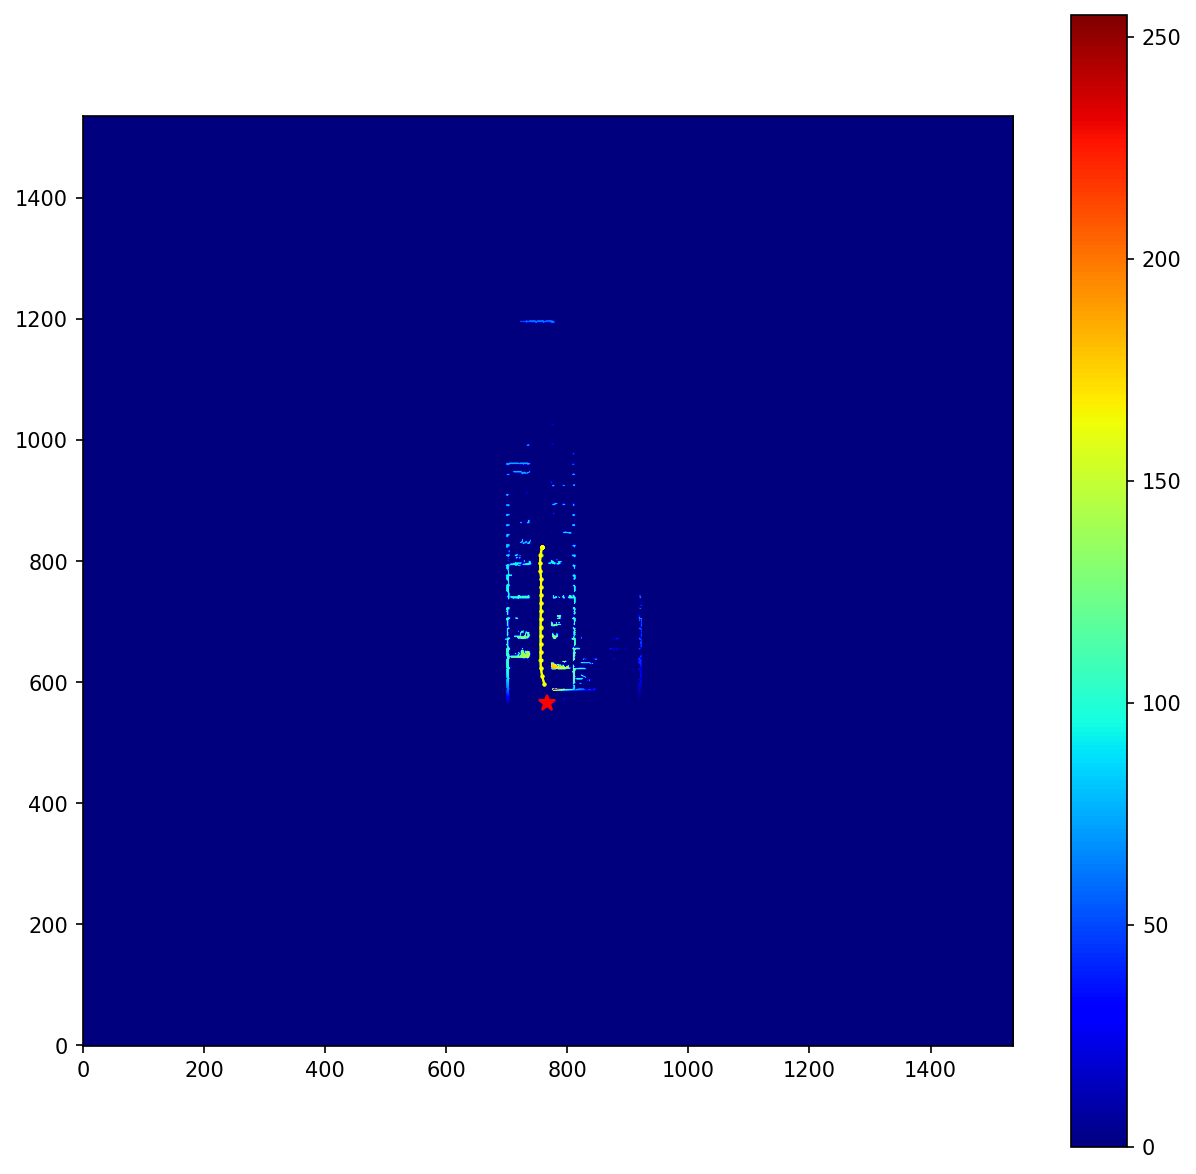

In [62]:
plt.figure(figsize=(10,10),dpi=150)
int_costmap = (sample_costmap*255).astype(np.uint8)
#print((int_costmap[565][698]))
plt.imshow(int_costmap,origin='lower',cmap = 'jet')
plt.colorbar()
plt.plot(sample_init_path[:,0],sample_init_path[:,1],'o-', color='lawngreen',markersize=1, linewidth=1)
plt.plot(sample_opt_path[:,0],sample_opt_path[:,1],'o-', color='yellow',markersize=1, linewidth=1)
plt.plot(sample_odo[0],sample_odo[1],'*', color = 'red',markersize=8)
print(sample_unequal_path_idx)

In [24]:
#cr_m = np.corrcoef(x = sample_diff_path,y=sample_fv)
pt_idx=3
#[print(sample_fv[pt_idx][i]) for i in range(sample_fv.shape[1])]
print(np.unique(sample_fv,return_index=True),"\n values:",len(np.unique(sample_fv)))
#np.max(fv)
print(np.unique(sample_fv,return_index=True,axis=0),"\n values:",len(np.unique(sample_fv)))



(array([0.        , 0.38298934, 0.38374816, 0.38381047, 0.38451177]), array([    0, 17648, 17647, 15594, 17646], dtype=int64)) 
 values: 5
(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([ 0, 14, 15, 16], dtype=int64)) 
 values: 5


## Print integer costmap and retrieved float cost map 

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 186 187 189 192 194 195 199 200 201 206 207 213 219
 220 226 227 232 233 234 238 239 241 243 246 248 249 252 254 255] 
 values: 214


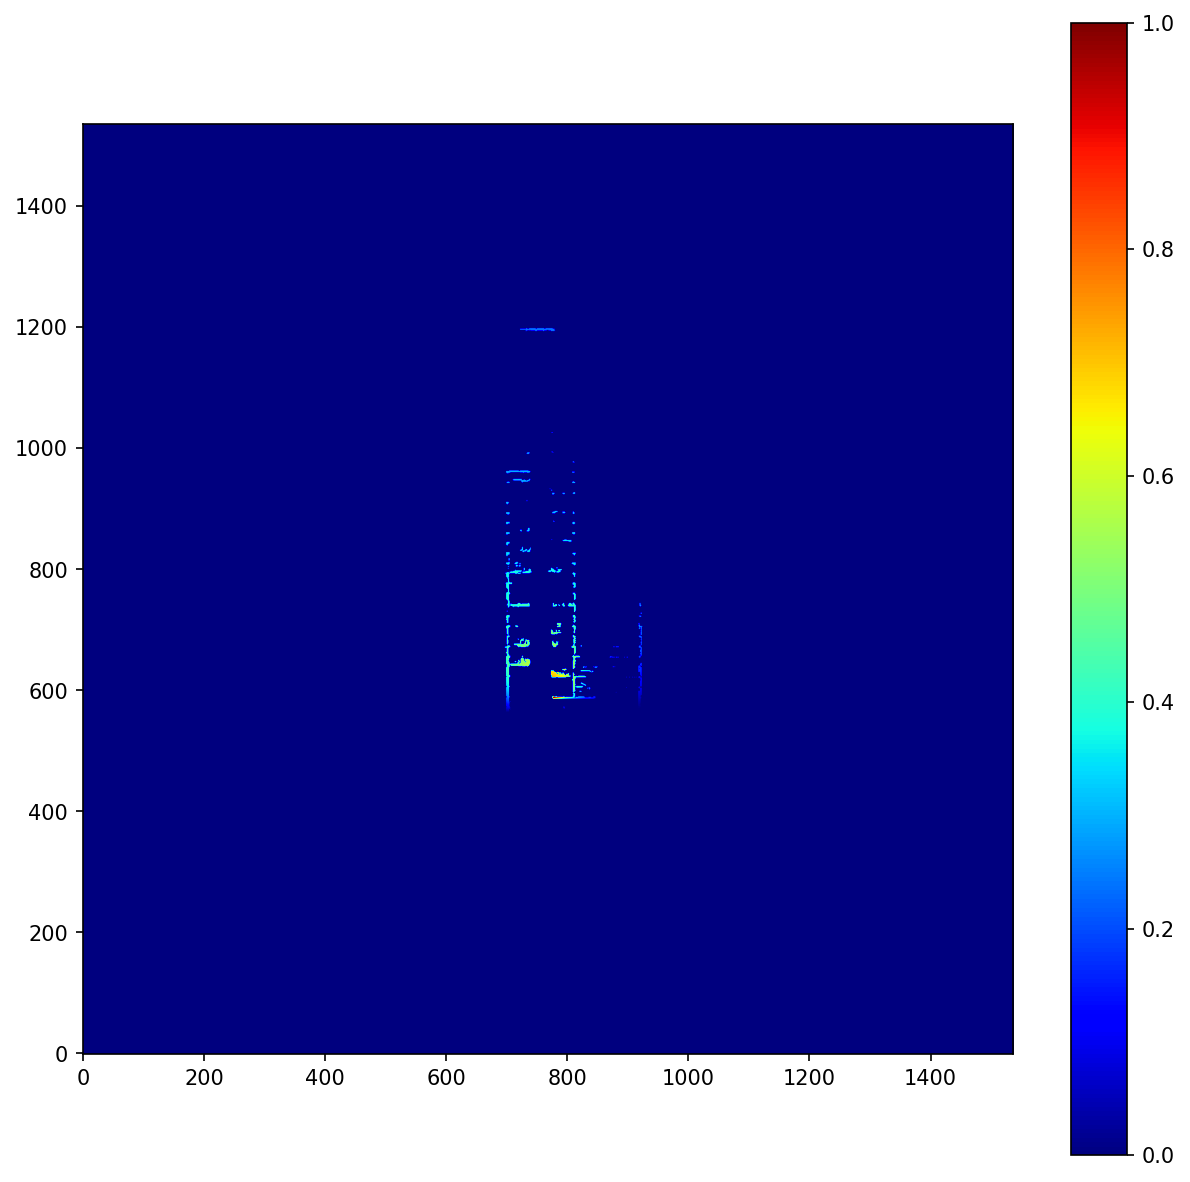

In [63]:
np.where(sample_costmap>0)
print(np.unique(int_costmap,return_index=False),"\n values:",len(np.unique(int_costmap)))
plt.figure(figsize=(10,10),dpi=150)
plt.imshow(int_costmap/255,origin='lower',cmap='jet')
plt.colorbar()

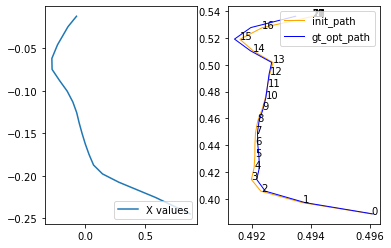

In [7]:

plt.subplot(1,2,1)
plt.plot(sample_diff_path[:,0],sample_diff_path[:,1])
#plt.plot(sample_diff_path[:,1])
plt.legend(
    [
        "X values",
        "Y values",
    ],
    loc="lower right",
)
sample_init_path=sample_init_path/1536
sample_opt_path = sample_opt_path/1536
plt.subplot(1,2,2)
plt.plot(sample_init_path[:,0],sample_init_path[:,1],'-', color='orange',markersize=1, linewidth=1)
[plt.annotate(s=i,xy=(sample_init_path)[i]) for i in range(len(sample_init_path))]
plt.plot(sample_opt_path[:,0],sample_opt_path[:,1],'-', color='blue',markersize=1, linewidth=1)

plt.legend(
    [
        "init_path",
        "gt_opt_path",
    ],
    loc="upper right",
)

In [8]:
sample_diff_path

array([[-0.07095077, -0.01235532],
       [-0.14190154, -0.02471063],
       [-0.22879463, -0.04596774],
       [-0.2756413 , -0.06198837],
       [-0.27380431, -0.0748786 ],
       [-0.21349844, -0.08765963],
       [-0.14838589, -0.10045277],
       [-0.10150013, -0.11316174],
       [-0.06944   , -0.12569329],
       [-0.04850262, -0.13796042],
       [-0.02447478, -0.1502863 ],
       [ 0.00223395, -0.16265604],
       [ 0.03350496, -0.17502929],
       [ 0.07078381, -0.18741265],
       [ 0.14507758, -0.19784411],
       [ 0.28067468, -0.20760477],
       [ 0.58393879, -0.22542981],
       [ 0.87411622, -0.24490364],
       [ 0.87411622, -0.24490364],
       [ 0.87411622, -0.24490364],
       [ 0.87411622, -0.24490364],
       [ 0.87411622, -0.24490364],
       [ 0.87411622, -0.24490364],
       [ 0.87411622, -0.24490364],
       [ 0.87411622, -0.24490364]])